In [1]:
import random
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.utils import resample

# 3-1. A/B 검정
- 2개의 feature 중 더 나은 것을 입증하기 위해 실험군을 2 Group으로 나누어 진행하는 실험
- Group은 특정 처리에 노출되었는가에 따라서 'Treatment(처리군,O)/Control(대조군,X)'로 구분된다.
- Randomization(임의화,랜덤화) :처리를 적용할 대상을 임의로 결정하는 과정
- Test statistic(검정통계량) : 처리 효과를 측정하기 위한 지표

# 3-2. 가설검정(Hypothesis Test)
- goal. 발생한 효과가 우연히 발생한 것인지를 검정함
- Null Hypothesis(귀무가설) : 우연 때문에 발생했을 것이라는 가설. 인간은 우연에 의미가 있을 것이라고 해석하는 경향이 있어서, 이를 배제하기 위함
- Alternative hypothesis(대립가설, <>귀무가설) : 증명하고자 하는 가설
- 'one/two'-way test : '한/양'방향으로 우연히 일어날 확률을 계산하는 가설검정

# 3-3. 재표본추출
- 변수들의 변동성을 측정하기 위해서, 표본에서 data를 반복 추출하는 것
- ML model's accuracy를 평가, 향상하기 위해서도 적용된다.
- Type) Bootstrap, permutation test(순열검정)

# 3-3-1. Permutation Test
- 데이터의 분포에 대한 가정을 하지 않는, Nonparametric methods(비모수적인 방법)
- 두 모집단의 data를 섞어가면서 검증함

1) 두 모집단 간에는 차이가 없다는 귀무가설을 설정한다.

2)통계량 계산 : 관측된 데이터로부터 특정한 통계량(예: 평균 차이, 중간값 차이 등)을 계산한다.

3)데이터 섞기 (순열) : 두 그룹의 데이터를 합쳐서 섞은 후, 다시 두 그룹으로 나누고, 이 과정을 여러 번 반복하여 새로운 표본을 생성.

4)통계량 계산 (순열 표본) : 각각의 순열된 데이터에 대해 동일한 통계량을 계산합니다.

5) P-값 계산 : 원래 데이터에서 계산한 통계량이 순열된 데이터의 통계량 중 어느 정도 극단적인지를 측정하여 P-값을 계산합니다.

In [ ]:
# 예제 : 웹 접착성
# Time이 클수록, user가 오래 머물었음을 의미한다.
session = pd.read_csv('/content/drive/MyDrive/Colab_Note/csv/web_page_data.csv')
session.head()

,Page,Time
0,Page A,0.21
1,Page B,2.53
2,Page A,0.35
3,Page B,0.71
4,Page A,0.67


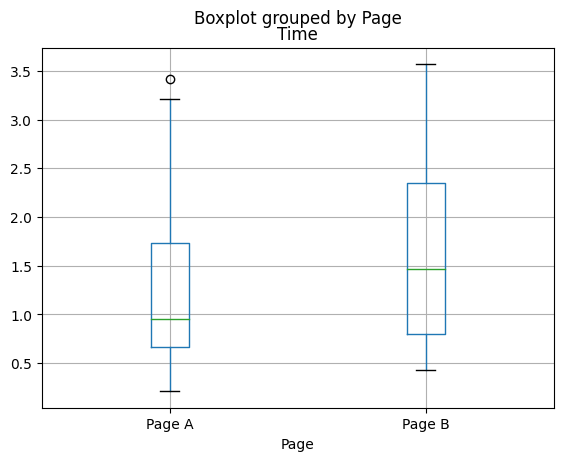

In [ ]:
ax = session.boxplot(by='Page', column='Time')

In [ ]:
# Column's Name을 이용해서 통계량을 측정할 수 있다.
mean_A = session[session.Page == 'Page A'].Time.mean()
mean_B = session[session.Page == 'Page B'].Time.mean()

mean_A, mean_B

(1.2633333333333332, 1.62)

In [ ]:
def perm_fun(x, nA, nB): # 순열검정 구현
  n = nA + nB
  idx_B = set(random.sample(range(n), nB))
  idx_A = set(range(n)) - idx_B
  return x.loc[idx_B].mean() - x.loc[idx_A].mean()

<ipython-input-39-88789c35c536>:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return x.loc[idx_B].mean() - x.loc[idx_A].mean()
<ipython-input-39-88789c35c536>:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return x.loc[idx_B].mean() - x.loc[idx_A].mean()
<ipython-input-39-88789c35c536>:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return x.loc[idx_B].mean() - x.loc[idx_A].mean()
<ipython-input-39-88789c35c536>:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return x.loc[idx_B].mean() - x.loc[idx_A].mean()
<ipython-input-39-88789c35c536>:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return x.loc[idx_B].mean() - x.loc[idx_A].mean()
<ipyt

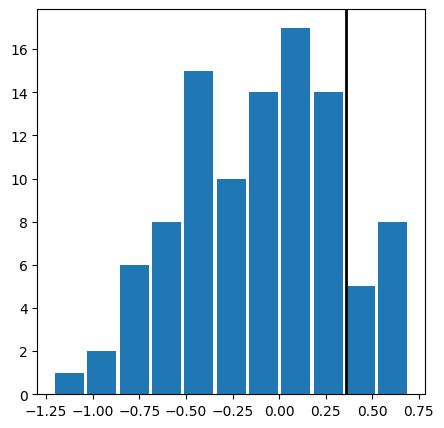

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5)) # 10개씩 섞는 걳을 100회 반복함
ax.hist([perm_fun(session.Time, 10, 10) for _ in range(100)], bins=11, rwidth=0.9)
ax.axvline(x=mean_B-mean_A, color='black', lw=2) # 측정값의 mean을 나타내는 선

# 3-4. 통계적 유의성과 p 값
- 실험 결과가 우연히 일어난 것인지, 혹은 일어나기 어려운 극단적인 것인지 판단하는 방법
- **유의하다** : 일어날 만한 범위 밖의 일인 경우
- p-value : 특이/극단적인 결과를 얻을 확률
- alpha : 측정된 결과가 '**통계적으로 유의미**'하기 위해서 넘어야 하는, '비상식적인 가능성의 확률 값'
- Type 'I/II' error : '우연'과 '실제 효과' 사이에 잘못된 인과 관계를 결론 내렸을 때 발생하는 error

In [ ]:
result = np.array([[200, 182], [23539, 22406]])
result = pd.DataFrame(result, columns=['price_A', 'price_B'], index=['True', 'False'])
result

,price_A,price_B
True,200,182
False,23539,22406


In [ ]:
# A, B 카드를 Box에 넣는다. Index (0,1)에는 (382, 45945)가 담길 것이다 (Clear)
result = pd.DataFrame(result.sum(axis=1))
result

,0
True,382
False,45945


In [ ]:
def perm_fun(x, nA, nB) :
  n = nA + nB
  idx_B = set(random.sample(range(n), nB))
  idx_A = set(range(n)) - idx_B
  return x.loc[idx_B].mean() - x.loc[idx_A].mean()

<ipython-input-39-88789c35c536>:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return x.loc[idx_B].mean() - x.loc[idx_A].mean()
<ipython-input-39-88789c35c536>:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return x.loc[idx_B].mean() - x.loc[idx_A].mean()
<ipython-input-39-88789c35c536>:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return x.loc[idx_B].mean() - x.loc[idx_A].mean()
<ipython-input-39-88789c35c536>:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return x.loc[idx_B].mean() - x.loc[idx_A].mean()
<ipython-input-39-88789c35c536>:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return x.loc[idx_B].mean() - x.loc[idx_A].mean()
<ipyt

(array([ 10.,  37.,  79., 150., 196., 249., 142.,  76.,  47.,  11.,   3.]),
 array([-0.23546887, -0.18912916, -0.14278945, -0.09644974, -0.05011003,
        -0.00377032,  0.04256939,  0.0889091 ,  0.13524881,  0.18158851,
         0.22792822,  0.27426793]),
 <BarContainer object of 11 artists>)

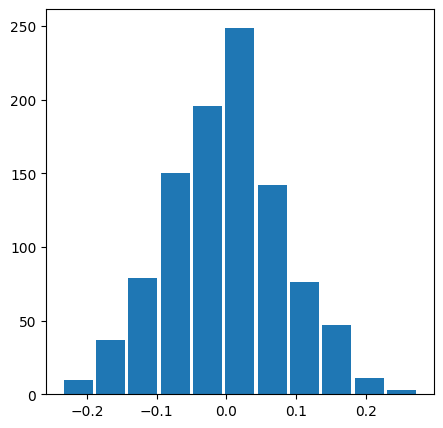

In [ ]:
# 23739(N(A))개를 뽑고, 그 중에서 1이 몇개인지 기록
conversion = [0] * 45945
conversion.extend([1] * 382)
# List는 loc[index] 사용하기 어려움 -> Series로 전환
conversion = pd.Series(conversion)

perm_diffs = [100 * perm_fun(conversion, 23739, 22588)
                for _ in range(1000)]

fig, ax = plt.subplots(figsize=(5, 5))
ax.hist(perm_diffs, bins=11, rwidth=0.9)

In [ ]:
# 나머지 22588(N(B))개를 뽑고, 1의 갯수를 기록한다.

In [ ]:
# 측정된 1의 비율 차이를 기록한다

In [ ]:
# Step 2~4를 반복했을 때, 실제 측정값 이상인 경우가 얼마나 자주 발생하는지 측정한다.

# 3-5. T-test (cf. T-Distribution)

In [ ]:
session.head()

,Page,Time
0,Page A,0.21
1,Page B,2.53
2,Page A,0.35
3,Page B,0.71
4,Page A,0.67


In [ ]:
# Calculate the T-test for the means of two independent samples of scores.
res = stats.ttest_ind(session[session.Page == 'Page A'].Time,
                      session[session.Page == 'Page B'].Time,
                      equal_var=False)
print(f'p-value for single sided test : {res.pvalue / 2:.4f}')

p-value for single sided test : 0.1408


# 3-6. 다중검정
- '데이터를 충분히 오래 고문하다 보면 뭐든지 털어놓을 것이다(XD)'는 말이 통계학에 있듯이, 우연에 의한 효과를 실제 효과라고 잘못 결론 내리는 제 1종 오류는 자주 발생한다.
- 이렇게 많은 테스트를 수행할수록 1종 오류가 일어날 확률이 증가하는 현상을 '알파 인플레이션'이라고 한다.
- 이 문제는 model이 Data mining 중에 잡음까지 과하게 학습하는 'Overfitting' 현상에서 비롯된다.
- Surpervisied Learning에서는 이 문제를 해결하기 위해서 'Hold-Out, K-교차 검증' 등의 기법을 이용한다.

# 3-7. 자유도(Degress of Freedom)
- 모집단에서 추출된 표본으로부터 계산되는 통계량의 수에서 사용된 제약 조건의 수를 뺀 것
- Ex. 1~5의 숫자들 중에서 하나씩을 지명하고, 이미 이용한 수는 다시 사용할 수 없다고 하자. 만약 4번째 수를 결정했다면, 남은 수는 1개밖에 없으므로, 5번재 수는 정해진다. 이렇게 정해지는 것을 '제약 조건'이라고 하며, 자유도는 5-1=4 이다.

# 3-8. Analysis of Variance(ANOVA, 분산분석)
- 'A/B/C' 처럼 수치로 구분되는 data에서 통계적으로 유의미한 차이를 검정하는 절차
- Pairwise Comparison(쌍별 비교) : 여러 그룹 중 2개 그룹에 대한 가설검정
- Omnibus Test(총괄검정) : 여러 그룹 평균값들의 전체 분산에 관한 단일 가설검정
- Decompositioon of Variance(분산분해) : 전체, 집단 등에 속한 분산을 개별 값으로 분해하는 것
- SS(Sum of Squares) : 어떤 평균으로부터의 분산들의 합
1) 모든 데이터를 한 집단으로 모은다
2) '6-1'개의 값을 갖는 4(nums of data)개의 재표본을 섞어서 추출한다.
3) 각 group의 mean, var을 기록한다.
4) 반복해가면서, 기록된 값들의 차이를 비교한다

# 3-8-1. F-statistic
- 그룹 평균 간의 차이를 '(랜덤 모델의) 예상치에서 벗어나는 정도'를 표준화한 통계량. ANOVA에 자주 이용됨
- python의 OLS model은 각각의 독립변수(x)가 종속변수(y)와 연관이 있는지 확인함

In [ ]:
session.head()

,Page,Time
0,Page A,0.21
1,Page B,2.53
2,Page A,0.35
3,Page B,0.71
4,Page A,0.67


In [ ]:
model = smf.ols('Time ~ Page', data=session).fit()
aov_table = sm.stats.anova_lm(model)
aov_table # sum_sq, mean_sq를 확일할 수 있다

,df,sum_sq,mean_sq,F,PR(>F)
Page,1.0,1.113097,1.113097,1.262711,0.26901
Residual,34.0,29.971467,0.881514,NaN,NaN


# 3-9. 카이제곱검정
- A/B 검정을 넘어서, 다변수를 한 번에 검정하기 위해 이용
- Pearson Residual : (관측값-기댓값)*(기댓값)**(-1/2)
- 카이제곱통계량(Pearson Residual의 제곱합) : 기댓값으로부터 관측값까지의 거리를 나타내는 통계량
- d.f. = degree of freedom
- 카이제곱통계량이 크다는 것은 곧 관측치가 기댓값 범위를 초과할 가능성이 높아짐을 의미한다. 그 정도를 p값으로 표현할 수 있다. (cf. 3-4)

In [ ]:
test = np.array([[14, 8, 12], [986, 992, 988]])
test = pd.DataFrame(data=test, columns=['A','B','C'], index=[1,0])
test

,A,B,C
1,14,8,12
0,986,992,988


In [2]:
estimated = np.array([[11.33, 11.33, 11.33], [988.67, 988.67, 988.67]])
estimated = pd.DataFrame(data=estimated, columns=['A','B','C'], index=[1,0])
estimated # 모두 같은 proability를 갖는다고 가정했을 때의 기댓값 분할표

,A,B,C
1,11.33,11.33,11.33
0,988.67,988.67,988.67


In [ ]:
def pearson(o, e) : # observed, estimated
  return (o-e)/(e**(1/2))

